In [1]:
import torch
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
import torch.nn as nn
from tqdm import tqdm
from sklearn.cluster import KMeans
from torch.utils.data import DataLoader, TensorDataset
from scipy.stats import pearsonr
import torch.nn.functional as F
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np

In [2]:
# Load
train_data = torch.load('train.pt')
val_data = torch.load('val.pt')
test_data = torch.load('test.pt')

# Prepare
def prepare_dataset(data):
    eeg_list, stim_list = [], []
    for eeg, stim in data:
        eeg_list.append(eeg.float())
        stim_list.append(stim.float())
    return torch.stack(eeg_list), torch.stack(stim_list)

X_train, y_train = prepare_dataset(train_data)
X_val, y_val = prepare_dataset(val_data)
X_test, y_test = prepare_dataset(test_data)

In [12]:
# config.py or at the top of your notebook
config = {
    "input_channels": 64,
    "seq_len": 320,
    "gcn_hidden": 64,
    "gcn_out": 32,
    "cnn_channels": 32,
    "cnn_kernel": 5,
    "lstm_hidden": 64,
    "lstm_layers": 1,
    "fc_out": 1,

    "dropout": 0.3,
    "learning_rate": 1e-3,
    "batch_size": 32,
    "epochs": 10,
    "weight_decay": 1e-5,

    # Loss weights
    "alpha": 1,  # Pearson
    "beta": 0.0,   # Cosine
    "gamma": 0.0,
}

In [22]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GraphConvLayer(nn.Module):
    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.theta = nn.Parameter(torch.FloatTensor(in_channels, out_channels))
        nn.init.xavier_uniform_(self.theta)

    def forward(self, x, adj):
        B, T, C = x.shape  # (B, T, C)
        
        # Apply adjacency to features (per time-step)
        # (B, T, C) -> (B, T, C), where adj is (C, C)
        x = torch.einsum('ij,btj->bti', adj, x)  # apply adj first

        # Then apply the learned transformation
        x = torch.matmul(x, self.theta)  # (B, T, out_channels)

        return F.relu(x)

class EEGReconstructionModel(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config

        self.gcn = GraphConvLayer(config["input_channels"], config["gcn_out"])

        self.cnn = nn.Conv1d(
            in_channels=config["gcn_out"],
            out_channels=config["cnn_channels"],
            kernel_size=config["cnn_kernel"],
            padding=config["cnn_kernel"] // 2
        )

        self.lstm = nn.LSTM(
            input_size=config["cnn_channels"],
            hidden_size=config["lstm_hidden"],
            num_layers=config["lstm_layers"],
            batch_first=True
        )

        self.dropout = nn.Dropout(config["dropout"])
        self.fc = nn.Linear(config["lstm_hidden"], config["fc_out"])

    def forward(self, x, adj):
        B, T, C = x.size()
        x = self.gcn(x, adj)         # (B, T, gcn_out)
        x = x.permute(0, 2, 1)       # (B, gcn_out, T)
        x = self.cnn(x)              # (B, cnn_channels, T)
        x = x.permute(0, 2, 1)       # (B, T, cnn_channels)
        x, _ = self.lstm(x)          # (B, T, lstm_hidden)
        x = self.dropout(x)
        x = self.fc(x).squeeze(-1)
        x = x.relu() # (B, T)
        return x


In [23]:


def pearson_corr(pred, target):
    vx = pred - torch.mean(pred, dim=1, keepdim=True)
    vy = target - torch.mean(target, dim=1, keepdim=True)
    corr = torch.sum(vx * vy, dim=1) / (torch.sqrt(torch.sum(vx ** 2, dim=1)) * torch.sqrt(torch.sum(vy ** 2, dim=1)) + 1e-8)
    return corr.mean()

def cosine_similarity(pred, target):
    pred_norm = F.normalize(pred, dim=1)
    target_norm = F.normalize(target, dim=1)
    return torch.sum(pred_norm * target_norm, dim=1).mean()


def pearson_corr_loss(pred, target):
    vx = pred - pred.mean(dim=1, keepdim=True)
    vy = target - target.mean(dim=1, keepdim=True)
    corr = torch.sum(vx * vy, dim=1) / (torch.sqrt(torch.sum(vx ** 2, dim=1)) * torch.sqrt(torch.sum(vy ** 2, dim=1)) + 1e-8)
    return 1 - corr.mean()

def cosine_sim_loss(pred, target):
    pred_norm = F.normalize(pred, p=2, dim=1)
    target_norm = F.normalize(target, p=2, dim=1)
    cos_sim = (pred_norm * target_norm).sum(dim=1)
    return 1 - cos_sim.mean()

def mse_loss(pred, target):
    return F.mse_loss(pred, target)

# Combined loss
def combined_loss(pred, target, config):
    alpha = config.get("alpha", 0.5)
    beta = config.get("beta", 0.5)
    gamma = config.get("gamma", 0.0)
    return (
        alpha * pearson_corr_loss(pred, target) +
        beta * cosine_sim_loss(pred, target) +
        gamma * mse_loss(pred, target)
    )


In [24]:
def train_model(model, train_loader, val_loader, config, device):
    optimizer = torch.optim.Adam(model.parameters(), lr=config["learning_rate"], weight_decay=config["weight_decay"])
    train_losses = []
    val_losses = []

    for epoch in range(config["epochs"]):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Epoch {epoch+1}/{config['epochs']}")
        
        for x_batch, y_batch in progress_bar:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adj = torch.eye(config["input_channels"]).to(device)

            pred = model(x_batch, adj)
            loss = combined_loss(pred, y_batch, config)
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            progress_bar.set_postfix({"Train Loss": loss.item()})

        epoch_train_loss = running_loss / len(train_loader)
        train_losses.append(epoch_train_loss)

        # --- Validation loop ---
        model.eval()
        val_running_loss = 0.0
        val_corrs = []
        val_cossims = []

        with torch.no_grad():
            for x_batch, y_batch in val_loader:
                x_batch, y_batch = x_batch.to(device), y_batch.to(device)
                adj = torch.eye(config["input_channels"]).to(device)

                pred = model(x_batch, adj)
                loss = combined_loss(pred, y_batch, config)
                val_running_loss += loss.item()

                # Metrics
                corr = pearson_corr(pred, y_batch).item()
                cos = cosine_similarity(pred, y_batch).item()
                val_corrs.append(corr)
                val_cossims.append(cos)

        epoch_val_loss = val_running_loss / len(val_loader)
        epoch_val_corr = sum(val_corrs) / len(val_corrs)
        epoch_val_cos = sum(val_cossims) / len(val_cossims)
        val_losses.append(epoch_val_loss)

        print(f"\nEpoch {epoch+1}: Train Loss = {epoch_train_loss:.4f} | "
              f"Val Loss = {epoch_val_loss:.4f} | Val Corr = {epoch_val_corr:.4f} | Val CosSim = {epoch_val_cos:.4f}")

In [25]:


train_loader = DataLoader(TensorDataset(X_train, y_train), batch_size=config["batch_size"], shuffle=True)
val_loader = DataLoader(TensorDataset(X_val, y_val), batch_size=config["batch_size"])

# Train
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = EEGReconstructionModel(config).to(device)
train_model(model, train_loader, val_loader, config, device)

Epoch 1/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:19<00:00, 143.05it/s, Train Loss=0.921]



Epoch 1: Train Loss = 0.9254 | Val Loss = 0.9204 | Val Corr = 0.0796 | Val CosSim = 0.7365


Epoch 2/10: 100%|█████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 142.32it/s, Train Loss=0.93]



Epoch 2: Train Loss = 0.9165 | Val Loss = 0.9186 | Val Corr = 0.0814 | Val CosSim = 0.7636


Epoch 3/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:19<00:00, 142.90it/s, Train Loss=0.896]



Epoch 3: Train Loss = 0.9130 | Val Loss = 0.9151 | Val Corr = 0.0849 | Val CosSim = 0.7257


Epoch 4/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 141.40it/s, Train Loss=0.904]



Epoch 4: Train Loss = 0.9105 | Val Loss = 0.9140 | Val Corr = 0.0860 | Val CosSim = 0.7740


Epoch 5/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 141.15it/s, Train Loss=0.896]



Epoch 5: Train Loss = 0.9076 | Val Loss = 0.9109 | Val Corr = 0.0891 | Val CosSim = 0.7469


Epoch 6/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 141.74it/s, Train Loss=0.877]



Epoch 6: Train Loss = 0.9070 | Val Loss = 0.9108 | Val Corr = 0.0892 | Val CosSim = 0.7716


Epoch 7/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 140.95it/s, Train Loss=0.821]



Epoch 7: Train Loss = 0.9052 | Val Loss = 0.9073 | Val Corr = 0.0927 | Val CosSim = 0.7654


Epoch 8/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 139.74it/s, Train Loss=0.876]



Epoch 8: Train Loss = 0.9044 | Val Loss = 0.9146 | Val Corr = 0.0854 | Val CosSim = 0.7886


Epoch 9/10: 100%|████████████████████████████████████████████████| 2856/2856 [00:20<00:00, 142.42it/s, Train Loss=0.759]



Epoch 9: Train Loss = 0.9028 | Val Loss = 0.9080 | Val Corr = 0.0920 | Val CosSim = 0.7757


Epoch 10/10: 100%|███████████████████████████████████████████████| 2856/2856 [00:19<00:00, 144.91it/s, Train Loss=0.878]



Epoch 10: Train Loss = 0.9019 | Val Loss = 0.9080 | Val Corr = 0.0920 | Val CosSim = 0.7768


In [26]:
def test_model(model, test_loader, config, device):
    model.eval()
    total_loss = 0.0
    total_corr = 0.0
    total_cos = 0.0
    with torch.no_grad():
        for x_batch, y_batch in test_loader:
            x_batch, y_batch = x_batch.to(device), y_batch.to(device)
            adj = torch.eye(config["input_channels"]).to(device)
            pred = model(x_batch, adj)

            loss = combined_loss(pred, y_batch, config)
            corr = pearson_corr(pred, y_batch)
            cos = cosine_similarity(pred, y_batch)

            total_loss += loss.item()
            total_corr += corr.item()
            total_cos += cos.item()

    avg_loss = total_loss / len(test_loader)
    avg_corr = total_corr / len(test_loader)
    avg_cos = total_cos / len(test_loader)

    print(f"\nTest Loss: {avg_loss:.4f} | Test PCC: {avg_corr:.4f} | Test CosSim: {avg_cos:.4f}")
    return avg_loss, avg_corr, avg_cos

In [27]:
test_loader = DataLoader(TensorDataset(X_test, y_test), batch_size=config["batch_size"])

# Evaluate
test_model(model, test_loader, config, device)


Test Loss: 0.9014 | Test PCC: 0.0986 | Test CosSim: 0.7715


(0.9014435596574987, 0.09855644016521913, 0.7714595869561742)

In [28]:
def plot_predictions(model, test_loader, config, device, num_samples=5):
    model.eval()
    with torch.no_grad():
        x_batch, y_batch = next(iter(test_loader))
        x_batch, y_batch = x_batch.to(device), y_batch.to(device)
        adj = torch.eye(config["input_channels"]).to(device)

        pred = model(x_batch, adj).cpu().numpy()
        y_batch = y_batch.cpu().numpy()

        for i in range(min(num_samples, x_batch.size(0))):
            plt.figure(figsize=(10, 3))
            plt.plot(y_batch[i], label='Original', linewidth=2)
            plt.plot(pred[i], label='Predicted', linestyle='--')
            plt.title(f"Sample {i+1}")
            plt.xlabel("Time")
            plt.ylabel("Envelope")
            plt.legend()
            plt.tight_layout()
            plt.show()

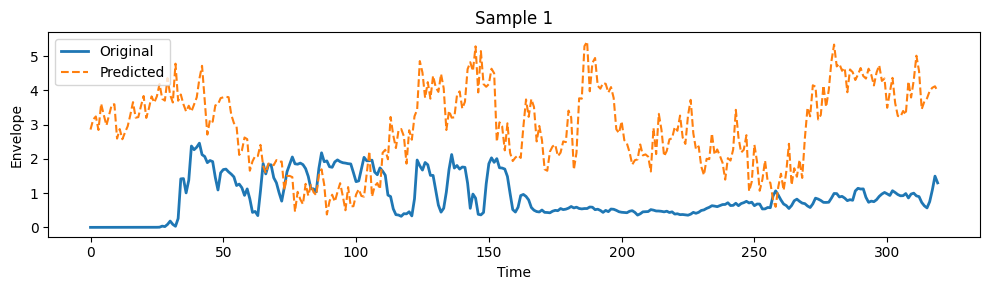

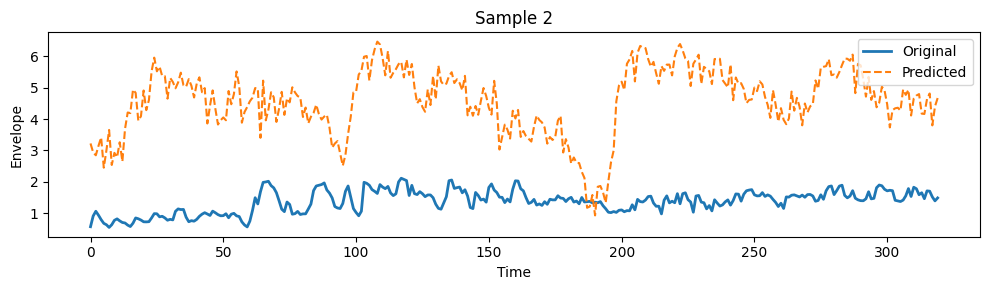

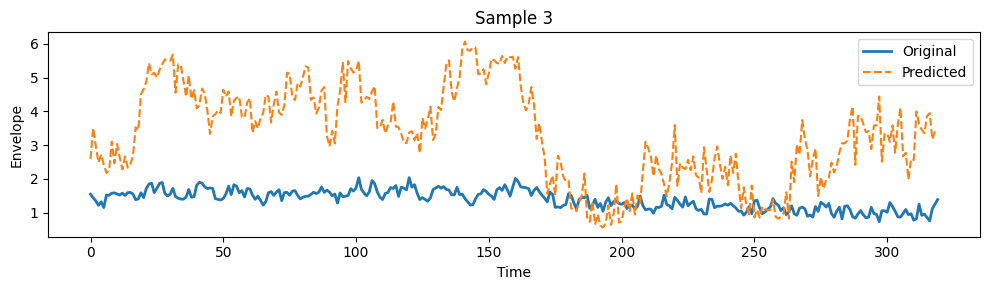

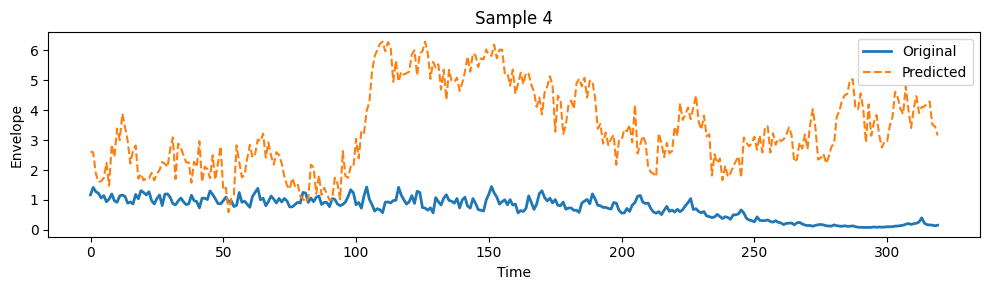

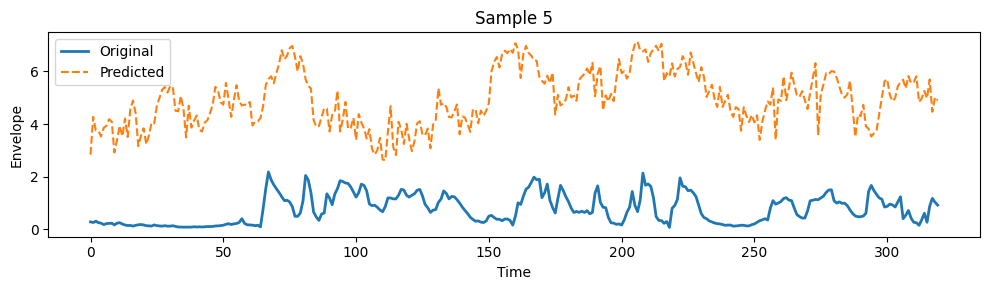

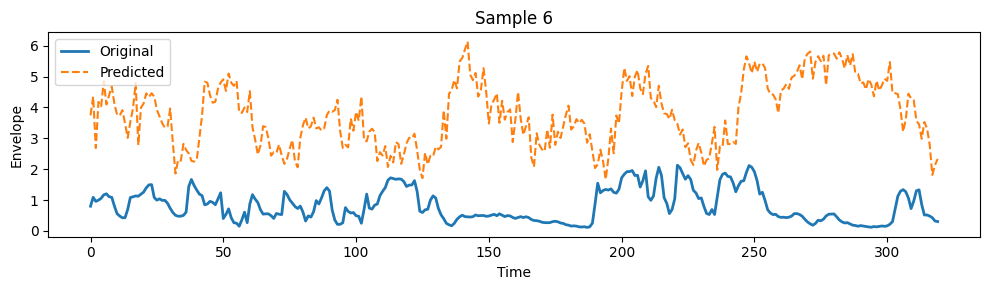

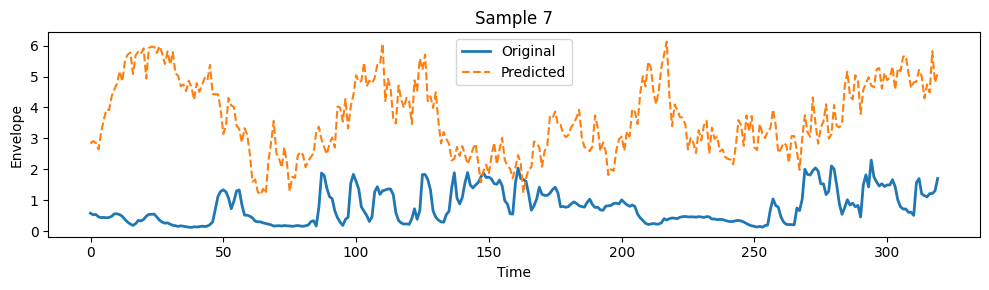

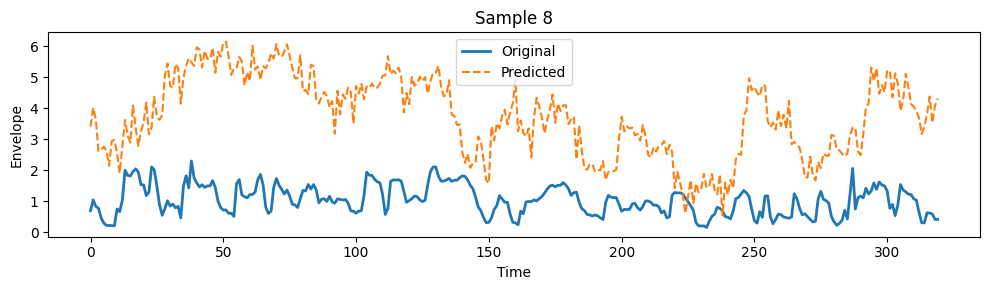

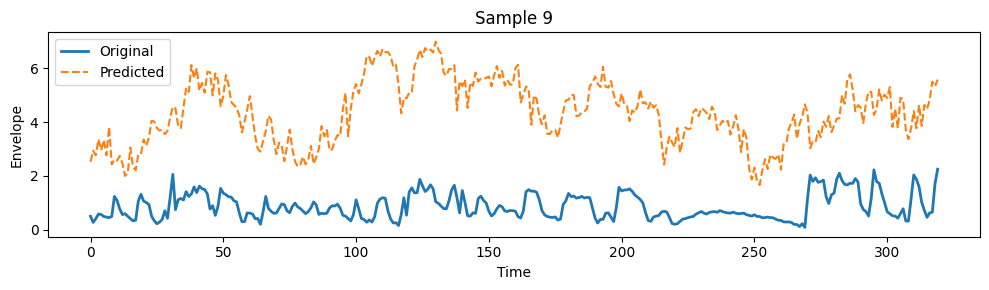

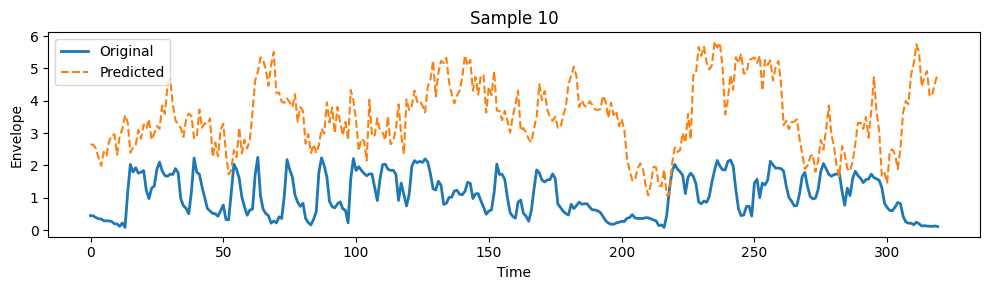

In [29]:
plot_predictions(model, test_loader, config, device, num_samples=10)
